### 비지도 학습
* 비지도 학습은 정답(타깃값, 라벨)없이 데이터의 특성을 파악하는 학습 방법이다.
* 즉, 모델에게 정답을 알려주지 않기 때문에 라벨링이 없는 데이터를 사용할 수 있다는 장점이 있다.
* 하지만 정답을 모르기 때문에 상대적으로 지도 학습 보다는 성능이 낮을 수 있다.
* 대표적인 비지도 학습의 종류로는 입력 데이터로부터 특성을 뽑아 유사 성질들을 군집화하는 클러스터링(Clustering)과 새로운 데이터를 생성해내는 오토인코더(Autoencoder)와 생성적 적대 신경망(GAN)이 있다.

### K-평균 알고리즘
* 클러스터링은 입력 데이터로부터 특성을 뽑아 유사 성질들을 군집화하는 비지도 학습이며 종류가 매우 다양하다.
* 정답이 없어 클러스터링의 종류에 따라 군집을 다르게 할 수 있다.
* K-means 알고리즘은 각 그룹의 평균을 기준으로 점들을 배치시키는 알고리즘이다.
* 이때, 특정 거리 함수를 통해 각 중심(Centroid)과 입력값의 거리를 측정하고 그 중 가장 가까운 그룹으로 할당한다.

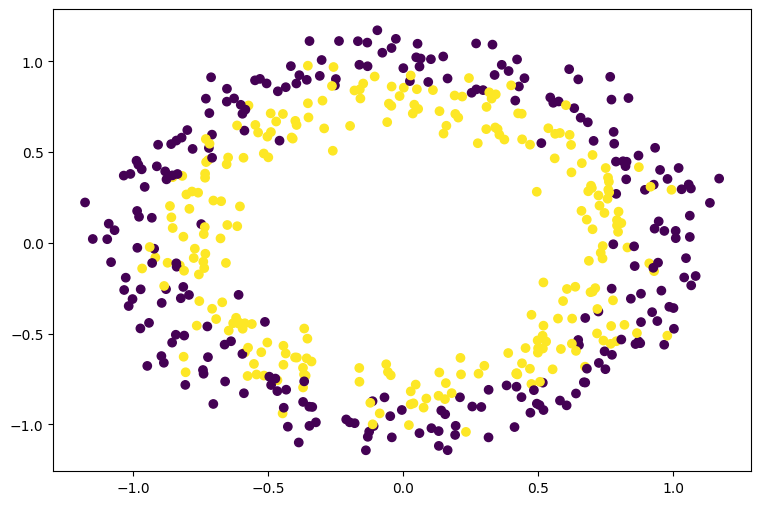

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# 500개의 샘플로 구성된 원형 데이터를 생성합니다.
# 'noise' 매개변수를 통해 데이터에 노이즈를 추가합니다.
# 이 때, 'x'는 각 샘플의 특징을, 'y'는 각 샘플의 레이블(클래스)를 저장합니다.
x,y = make_circles(n_samples=500, noise=0.1)
plt.figure(figsize=(9,6))
# scatter 함수는 산점도를 그린다.
# 첫 번째 인수 x[:,0]와 두 번째 인수 x[:,1]는 각각 'x'의 모든 행과 첫 번째 열,
# 그리고 두 번째 열을 나타낸다.
plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

### 텐서 데이터 변환하기

In [12]:
x = torch.FloatTensor(x)

### K-평균 알고리즘

In [21]:
# 함수는 두 텐서 'a'와 'b' 사이의 요소별 차이를 제곱하여 합산한 후, 그 결과 중에서 가장 작은 값을 가지는 요소의 인덱스를 반환한다.
def l2distance(a,b):
  return torch.argmin(torch.sum((a-b)**2, dim=1),dim=0)
# torch.sum( ..., dim=1): 'dim=1'에 따라 텐서의 각 행에 대한 합계를 계산한다.
# 그 다음, 'dim=0'에 따라 텐서의 각 열에서 최소값의 인덱스를 찾는다.

In [20]:
def kmeans (x, num_clusters=2, max_iteration=5):
  device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  x=x.to(device) # 입력 데이터를 선택된 장치(device)로 이동시킨다.
  centroids=torch.rand(num_clusters,x.size(1)).to(device) # 랜덤한 초기 중심점(centroids)을 설정하고 선택된 장치로 이동시킨다.
  for update in range(max_iteration): # 최대 반복 횟수만큼 K-means 알고리즘을 수행한다.
    y_assign=[]
    for m in range(x.size(0)):
      h=x[m].expand(num_clusters,-1)
      # 'x' 텐서의 'm' 번째 행을 선택한다.
      # 그리고 expand 메서드는 이 텐서를 입력으로 받아 num_clusters 행을 가진 새로운 텐서를 생성한다.
      # 이 때, 각 행은 원래 x[m] 행의 복사본이다.
      # -1은 텐서의 해당 차원의 크기를 자동으로 유추하도록 한다.
      assign=l2distance(h,centroids) # 이전에 정의한 l2distance 함수를 이용하여 각 데이터 포인트와 현재의 중심점 간의 거리를 계산한다.
      y_assign.append(assign.item()) # 계산한 거리를 y_assign 리스트에 추가한다.

    y_assign=np.array(y_assign)  # 리스트를 numpy 배열로 변환한다.
    if update!=max_iteration-1:
      for i in range(num_clusters):
        idx = np.where(y_assign==i)[0]
        # 이 코드는 NumPy의 where 함수를 사용하여 특정 조건을 만족하는 배열의 인덱스를 찾는 것이다.
        # y_assign==i는 'y_assign' 배열의 각 요소가 'i'와 같은지를 비교하고, 그 결과를 불리언(Boolean) 형태의 배열로 반환한다.
        centroids[i]=torch.mean(x[idx],dim=0).cpu() # 같은 클러스터에 속한 모든 데이터 포인트의 평균을 새로운 중심점으로 설정한다.
  return y_assign, centroids.cpu()

### 알고리즘 실행 및 그래프 그리기
* K-MEANS 알고리즘은 sklearn에서 제공하는 from sklearn.cluster import KMEANS가 많이 사용된다.
* 하지만 파이토치를 통해 코드를 작성한다면 추후에 GPU 연산도 할 수 있으며 requires_grad를 사용하여 다른 모델과 조합할 경우 역전파도 이용할 수 있다.

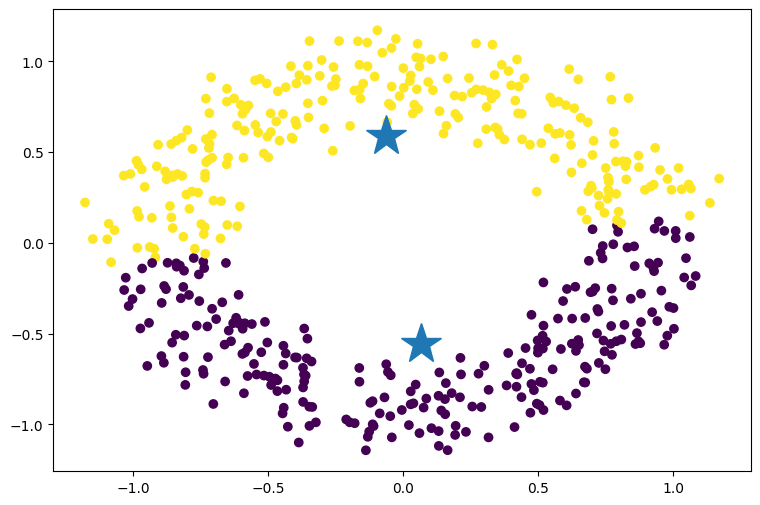

In [22]:
# kmeans 함수를 호출하여 데이터 x를 2개의 클러스터로 분류한다.
# y_pred는 각 데이터 포인트의 클러스터 인덱스를, centroids는 각 클러스터의 중심점 좌표를 나타낸다.
y_pred, centroids = kmeans(x, 2)

plt.figure(figsize=(9,6)) # 새로운 그림을 생성하며, 그림의 크기를 가로 9인치, 세로 6인치로 설정한다.
plt.scatter(x[:,0],x[:,1],c=y_pred)
# scatter 함수를 사용하여 2차원 산점도를 그린다.
# x[:,0]와 x[:,1]는 각각 'x'의 모든 행과 첫 번째 열, 그리고 두 번째 열을 나타낸다.
# 이는 'x'의 두 특징값을 각각 x축, y축에 대응시킨다. c=y_pred는 각 점의 색상을 'y_pred' 값에 따라 다르게 설정한다.
plt.plot(centroids[:,0],centroids[:,1],'*',markersize=30)
plt.show()

### 오토인코더
* 오토인코더는 정답 없이 모델을 학습시키는 비지도 학습 모델이다.
* 일반적으로 대칭형 구조를 지니고 있다.
* 입력 데이터를 압축하는 인코더(Encoder)부분과 압축을 푸는 디코더(Decoder)부분으로 구성되어 있다.
* 인코더를 통해 차원 축소가 된 잠재 변수(Latent variable)를 가지고 별도로 계산할 수도 있고, 디코더를 통해 입력값과 유사한 값을 생성할 수도 있다.
* 기본적으로 입력값 X와 츨력값 X`를 이용하여 MSE를 정의하고 이를 기준으로 학습을 진행한다.
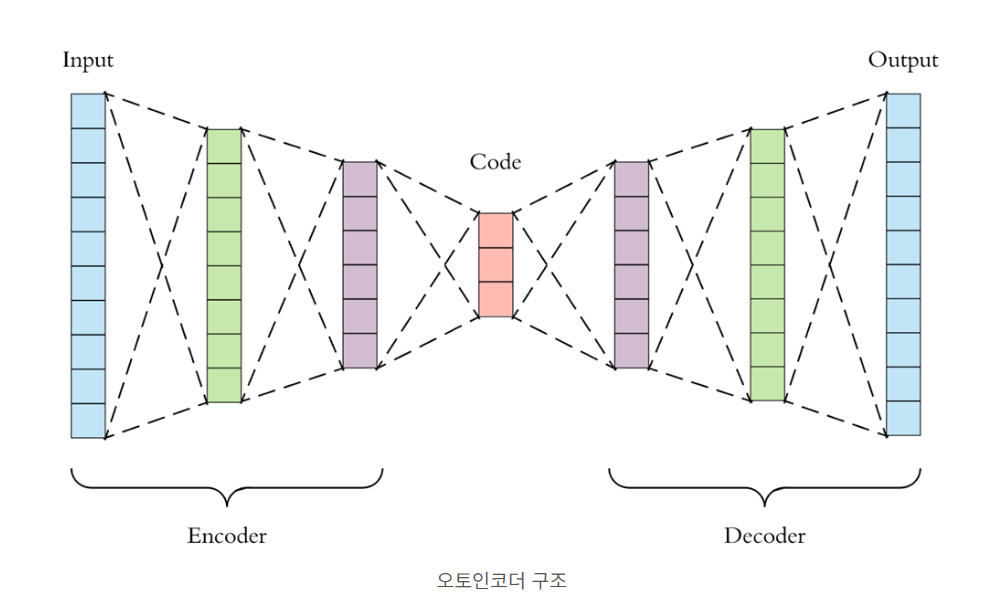


## 스택 오토인코더

#### 라이브러리 불러오기

In [23]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


### MNIST 데이터 불러오기

In [25]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 112711623.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41570244.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44916260.62it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20462436.92it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 모델 구축하기

In [27]:
class Autoencoder(nn.Module):
    def __init__(self):
        # nn.Sequential은 여러 신경망 계층을 순서대로 연결하는 컨테이너이다.
        # 여기서는 선형 계층(nn.Linear)과 활성화 함수(nn.ReLU)를 번갈아가며 연결하여 인코더를 구성하고 있다.
        # 마찬가지로 nn.Sequential를 사용하여 디코더를 구성한다.
        # 디코더는 인코더의 구조를 역순으로 따르며, 입력 데이터를 복원하는 역할을 한다.
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
                        nn.Linear(784, 128),
                        nn.ReLU(),
                        nn.Linear(128, 32),
                        nn.ReLU(),
                        nn.Linear(32, 10),
                        nn.ReLU())
        self.decoder = nn.Sequential(
                        nn.Linear(10, 32),
                        nn.ReLU(),
                        nn.Linear(32, 128),
                        nn.ReLU(),
                        nn.Linear(128, 28*28)
                        #nn.Sigmoid()
        )

    # forward 메서드는 신경망의 순전파를 정의한다.
    # 이 메서드는 입력 데이터 x를 받아 인코더를 통과시킨 후, 그 결과를 디코더를 통과시키고 최종 출력을 반환한다.
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 모델, 손실 함수, 최적화 기법 정의하기
* 우리의 목적은 입력 이미지와 유사한 출력 이미지를 얻는 것이다.
* 따라서 입력 이미지와 출력 이미지의 L2 거리를 계산하는 MSE 손실 함수를 사용하고 최적화 방법은 Adam을 사용한다.

In [28]:
model = Autoencoder().to(device)
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### 학습하기

In [29]:
for epoch in range(51):

    running_loss = 0.0 # 각 에포크 시작 전에 누적 손실값을 0으로 초기화한다.
    for data in trainloader: # trainloader는 학습 데이터를 불러오는 데이터 로더이다. 이 로더는 배치 크기만큼의 데이터를 반복적으로 제공함으로써 미니 배치 학습을 가능하게 한다.

        inputs = data[0].to(device) # 현재 배치의 입력 데이터를 GPU로 이동시킨다.
        optimizer.zero_grad() # 각 배치에서 기울기를 새로 계산하기 전에 이전 배치에서 계산한 기울기를 초기화한다.
        outputs = model(inputs.view(-1,28*28)) # 입력 데이터를 모델에 전달하여 순전파를 수행하고, 그 결과를 outputs에 저장한다. inputs.view(-1,28*28)는 입력 데이터의 형태를 변경하여 모델에 맞추는 작업이다.
        outputs = outputs.view(-1,1,28,28) # 출력 데이터의 형태를 변경하여 손실 함수에 맞춘다.
        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교한다.

        loss.backward() # 손실에 대한 그래디언트를 계산하기 위해 역전파를 수행한다.
        optimizer.step() # 계산된 그래디언트를 사용하여 모델의 가중치를 업데이트한다.
        running_loss += loss.item() # 현재 배치의 손실을 누적 손실에 더한다.

    cost = running_loss / len(trainloader) # 누적 손실을 배치의 개수로 나누어 평균 손실을 계산한다.
    print('[%d] loss: %.3f' %(epoch + 1, cost))


[1] loss: 0.057
[2] loss: 0.041
[3] loss: 0.038
[4] loss: 0.036
[5] loss: 0.035
[6] loss: 0.034
[7] loss: 0.033
[8] loss: 0.033
[9] loss: 0.032
[10] loss: 0.032
[11] loss: 0.032
[12] loss: 0.031
[13] loss: 0.031
[14] loss: 0.030
[15] loss: 0.030
[16] loss: 0.030
[17] loss: 0.030
[18] loss: 0.029
[19] loss: 0.029
[20] loss: 0.029
[21] loss: 0.029
[22] loss: 0.029
[23] loss: 0.029
[24] loss: 0.028
[25] loss: 0.028
[26] loss: 0.028
[27] loss: 0.028
[28] loss: 0.028
[29] loss: 0.028
[30] loss: 0.028
[31] loss: 0.028
[32] loss: 0.028
[33] loss: 0.028
[34] loss: 0.028
[35] loss: 0.027
[36] loss: 0.027
[37] loss: 0.027
[38] loss: 0.027
[39] loss: 0.027
[40] loss: 0.027
[41] loss: 0.027
[42] loss: 0.027
[43] loss: 0.027
[44] loss: 0.027
[45] loss: 0.027
[46] loss: 0.027
[47] loss: 0.027
[48] loss: 0.027
[49] loss: 0.027
[50] loss: 0.027
[51] loss: 0.027


In [32]:
def normalize_output(img):
    img = (img - img.min())/(img.max()-img.min())
    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs.view(-1,28*28))
            outputs = outputs.view(-1,1,28,28)

            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지

            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비
    rows = 5 # 시각화 전체 높이

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()
    plt.close()

    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()

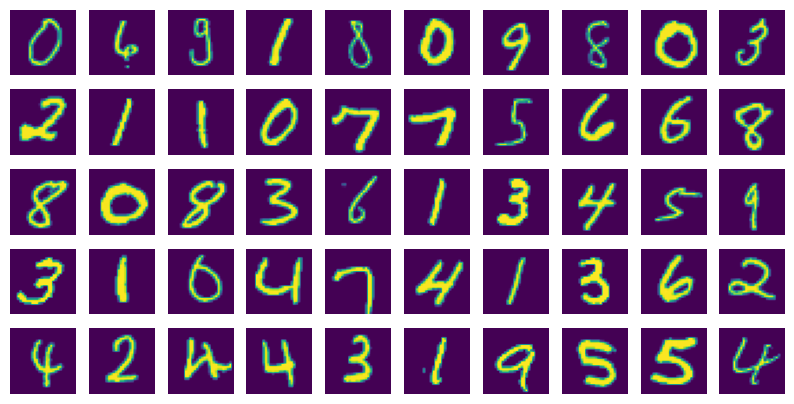

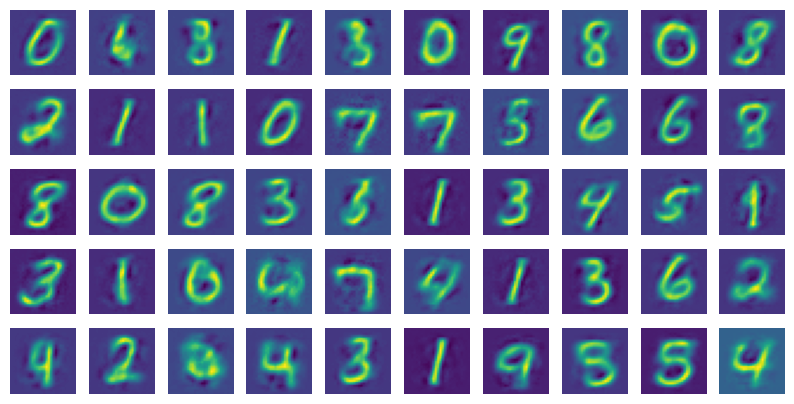

In [33]:
check_plot()

## 디노이징 오토인코더
* 오토인코더의 기본적인 목적은 새로운 데이터를 만드는 것이다.
* 따라서 출력 데이터를 입력 데이터에 가까워지도록 학습한다면 기존 데이터와 매우 유사하여 새로운 데이터를 만드는 의미가 무색해진 수 있다.
* 따라서 입력값에 과적합되지 않도록 입력값에 노이즈를 주입시키거나 신경망에 드롭아웃을 적용하여 출력 데이터를 생성하고 출력 데이터와 노이즈가 없는 원래 입력 데이터를 가지고 손실 함수를 계산한다.
* 노이즈가 있는 이미지를 가지고 노이즈가 없는 이미지와 유사한 데이터를 만드는 구조이기 때문에 이를 디노이징 오토인코더(Denoising autoencoder)라고 한다.


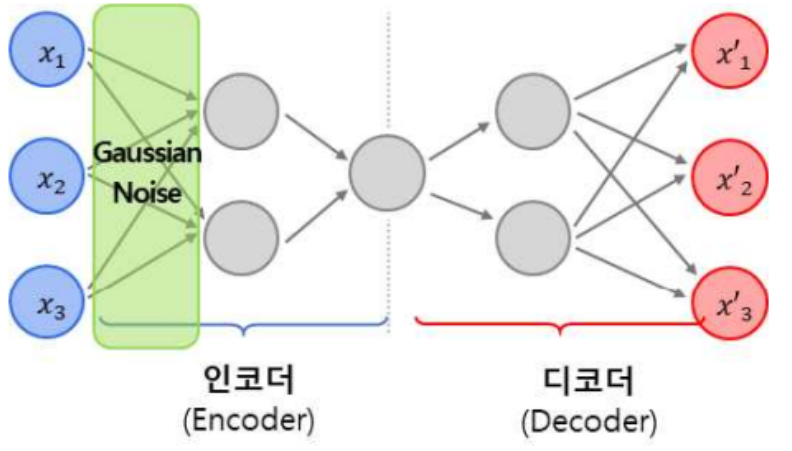

In [34]:
for epoch in range(51):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)
        optimizer.zero_grad()
        # 입력 이미지에 정규분포를 따르는 노이즈를 추가하여 dirty_inputs를 생성한다.
        # 이렇게 하면 모델은 노이즈가 추가된 이미지를 깨끗한 이미지로 복원하도록 학습하게 된다.
        dirty_inputs = inputs + torch.normal(0, 0.5, size=inputs.size()).to(device)
        outputs = model(dirty_inputs.view(-1,28*28))
        outputs = outputs.view(-1,1,28,28)
        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    cost = running_loss / len(trainloader)
    print('[%d] loss: %.3f' %(epoch + 1, cost))

[1] loss: 0.033
[2] loss: 0.031
[3] loss: 0.031
[4] loss: 0.031
[5] loss: 0.030
[6] loss: 0.030
[7] loss: 0.030
[8] loss: 0.030
[9] loss: 0.030
[10] loss: 0.030
[11] loss: 0.030
[12] loss: 0.030
[13] loss: 0.030
[14] loss: 0.029
[15] loss: 0.029
[16] loss: 0.029
[17] loss: 0.029
[18] loss: 0.029
[19] loss: 0.029
[20] loss: 0.029
[21] loss: 0.029
[22] loss: 0.029
[23] loss: 0.029
[24] loss: 0.029
[25] loss: 0.029
[26] loss: 0.028
[27] loss: 0.028
[28] loss: 0.028
[29] loss: 0.028
[30] loss: 0.028
[31] loss: 0.028
[32] loss: 0.028
[33] loss: 0.028
[34] loss: 0.028
[35] loss: 0.028
[36] loss: 0.028
[37] loss: 0.028
[38] loss: 0.028
[39] loss: 0.028
[40] loss: 0.028
[41] loss: 0.028
[42] loss: 0.028
[43] loss: 0.028
[44] loss: 0.028
[45] loss: 0.028
[46] loss: 0.028
[47] loss: 0.028
[48] loss: 0.028
[49] loss: 0.027
[50] loss: 0.027
[51] loss: 0.027


In [ ]:
check_plot()

### 합성곱 오토인코더
* nn.Linear 대신 합성곱 층 nn.Conv2d를 사용하는 구조다.
* 따라서 이미지 데이터가 일렬로 펴지지 않고 그대로 들어와 연산이 진행된다.
* 기본적으로 잠재 변수 h는 일렬 형태인 벡터이기 때문에, 인코더에서 나온 피처맵을 일렬로 펴서 h를 추출하고 다시 h를 은닉층을 거친 뒤 사각형 모양의 피쳐맵으로 만들어 디코더에 넣어준다.

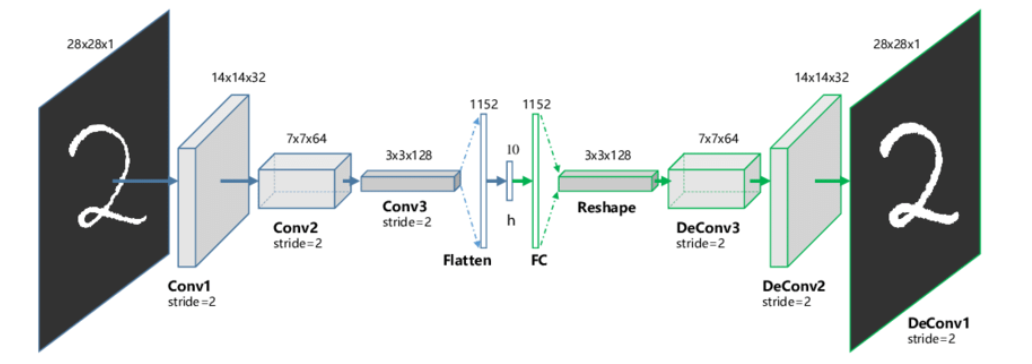

#### 피쳐맵을 벡터화하기

In [37]:
class Flatten(torch.nn.Module): # 4D -> 2D로 계산하기
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1) # (배치 수, 채널 수, 이미지 너비, 이미지 높이) -> (배치 수, 채널 수*이미지 너비*이미지 높이)

### 벡터를 사각형 피쳐맵으로 변환하기

In [38]:
class Deflatten(nn.Module): # 2D -> 4D로 계산하기
    def __init__(self, k):
        super(Deflatten, self).__init__()
        self.k = k

    def forward(self, x):
        # 입력 텐서의 크기를 s에 저장한다.
        s = x.size()
        # 입력 벡터의 길이(s[1])를 채널 수(self.k)로 나눈 후 제곱근을 취하여 이미지의 너비와 높이(feature_size)를 계산한다.
        feature_size = int((s[1]//self.k)**.5)

        # view 메서드를 사용하여 입력 텐서의 형태를 변경합니다. 변경된 형태는 (배치 수, 채널 수, 이미지 너비, 이미지 높이)이다.
        return x.view(s[0],self.k,feature_size,feature_size)

### 모델 구축하기

In [39]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        k = 16
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, k, 3, stride=2),
                        nn.ReLU(),
                        nn.Conv2d(k, 2*k, 3, stride=2),
                        nn.ReLU(),
                        nn.Conv2d(2*k, 4*k, 3, stride=1),
                        nn.ReLU(),
                        Flatten(),
                        nn.Linear(1024, 10),
                        nn.ReLU()
        )

        # ConvTranspose2d
        # 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출한다.
        # 출력 된 벡터는 행렬 형태로 변환한다.
        self.decoder = nn.Sequential(
                        nn.Linear(10, 1024),
                        nn.ReLU(),
                        Deflatten(4*k),
                        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), # (입력 채널 수, 출력 채널 수, 필터 크기, stride)
                        nn.ReLU(),
                        nn.ConvTranspose2d(2*k, k, 3, stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(k, 1, 3, stride=2,output_padding=1),
                        nn.Sigmoid()
        )

    def forward(self, x):

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

### 모델, 손실 함수, 최적화 기법 정의하기

In [41]:
model = Autoencoder().to(device)
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 학습하기

In [42]:
for epoch in range(51):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    cost = running_loss / len(trainloader)

    if epoch % 10 == 0:
        print('[%d] loss: %.3f' %(epoch + 1, cost))

[1] loss: 0.091
[11] loss: 0.025
[21] loss: 0.024
[31] loss: 0.023
[41] loss: 0.022
[51] loss: 0.022


* 합성곱 오토인코더는 오토인코더와 학습 과정은 동일하다.
* 차이점은 이미지를 그대로 받아서 학습하기 때문에 별도의 크기 변환이 필요없다.
* 합성곱 오토인코더는 이미지 처리에서는 기본 신경망을 사용하는 오토인코더 보다 성능이 뛰어나다.

In [44]:
def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs)

            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비
    rows = 5 # 시각화 전체 높이

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    # 원래 이미지 배치 크기 만큼 보여주기
    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze()) # 1채널인 경우 2로 변환
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

    # 생성 이미지 배치 크기 만큼 보여주기
    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

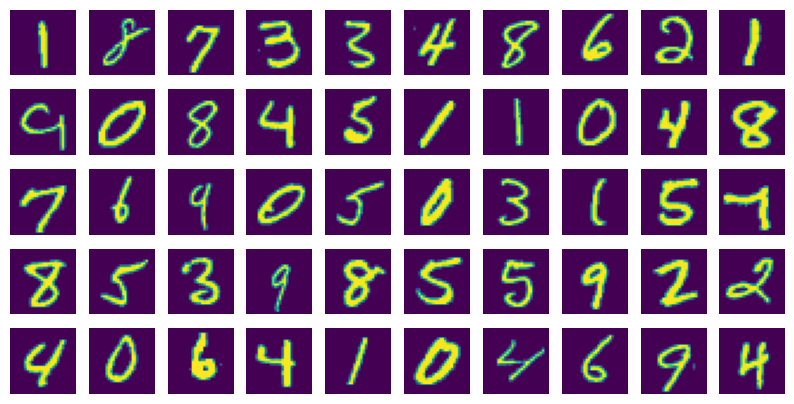

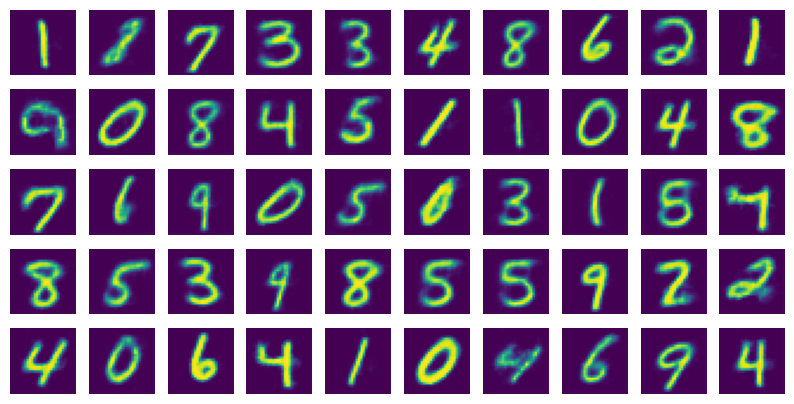

In [45]:
check_plot()